# Getting Well A and Well B traces

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
im = Image.open('SeismicScaled.jpg')
rgb_im = im.convert('RGB')
arr = np.array(rgb_im)

In [3]:
y_size = len(arr)
x_size = len(arr[0])
x_size,y_size

(1437, 781)

In [4]:
df = pd.DataFrame.from_records(arr)

In [5]:
df = df.T

In [6]:
stacked = df.stack()
stacked = stacked.reset_index()
stacked[['r','g','b']] = pd.DataFrame(stacked[0].values.tolist(), index=stacked.index)
stacked.columns = ['x','y','drop','r','g','b']
stacked.drop('drop', axis = 1, inplace = True)
stacked_pix = stacked

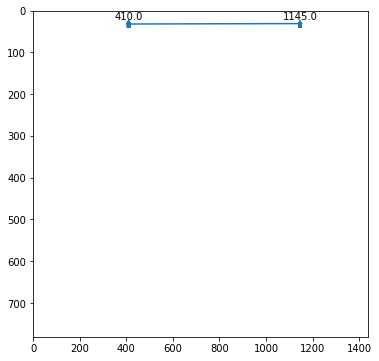

In [7]:
star = stacked[(stacked.r<160)&(stacked.g<160)&(stacked.b>200)]

star_a = star[star.x<800]
star_b = star[star.x>800]
star_a_x = star_a.x.median()
star_b_x = star_b.x.median()
star_a_y = star_a.y.median()
star_b_y = star_b.y.median()

plt.figure(figsize=(6,6))
plt.plot(star.x,star.y)
plt.xlim(0,x_size)
plt.ylim(0,y_size)
plt.gca().invert_yaxis()
plt.text(star_a_x, star_a_y-10, str(star_a_x),horizontalalignment='center')
plt.text(star_b_x, star_b_y-10, str(star_b_x),horizontalalignment='center')
plt.show()


In [8]:
a_trace=stacked[stacked.x == star_a_x]
b_trace=stacked[stacked.x == star_b_x]
len(a_trace),len(b_trace)

(781, 781)

# Upscaling well data

In [9]:
xls1 = pd.read_excel('WellACoreDescription.xlsx', header = None)
xls2 = pd.read_excel('WellBCoreDescription.xlsx', header = None)

In [10]:
xls1.columns = ['Depth','Lithology']
xls2.columns = ['Depth','Lithology']

In [11]:
xls1.Depth.min(),xls1.Depth.max()

(3999.06538856438, 6099.91959999515)

In [12]:
xls2.Depth.min(),xls2.Depth.max()

(3959.0996365139, 5159.86959999589)

In [13]:
def upscaling(xls,f,layers,lith = True):
    if lith:
        xls.columns = ['Depth','Lithology']
    else:
        xls.columns = ['Depth','Porosity']
    xls['Depth'] = round(xls['Depth'],1)
    if layers == "":
        layers = np.arange(xls.iloc[0]['Depth'],xls.iloc[-1]['Depth']+2.5,2.5)
    def lay(x):
        for i in range(0,len(layers)-1):
            if (x >= layers[i]) and (x <= layers[i+1]):
                return layers[i]
    xls['Tops'] = xls['Depth'].apply(lambda x: lay(x))
    xls_upscale = xls.groupby(xls['Tops'], as_index=False).agg(lambda x: x.value_counts().index[0])
    xls_upscale.drop('Depth', axis = 1, inplace = True)
    if lith:
        xls_upscale['Score'] = xls_upscale['Lithology'].replace({'sandstone':f-10,'shale':f+10})
    return xls_upscale,layers

In [14]:
core_A, lay_A = upscaling(xls1,star_a_x,"")
core_B, lay_B = upscaling(xls2, star_b_x,"")

In [15]:
xls3 = pd.read_excel('WellA.xlsx', header = None)
xls4 = pd.read_excel('WellB.xlsx', header = None)

In [16]:
log_A,_ = upscaling(xls3,star_a_x,lay_A,lith = False)
log_B,_ = upscaling(xls4, star_b_x,lay_B,lith = False)

d:\Users\zaytel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [17]:
well_A_upscale = pd.concat([core_A, log_A.drop(['Tops'],axis=1)], axis=1, sort=False)
well_B_upscale = pd.concat([core_B, log_B.drop(['Tops'],axis=1)], axis=1, sort=False)

In [18]:
well_A_upscale.to_csv('WellAUpscaled.csv',index=False)
well_B_upscale.to_csv('WellBUpscaled.csv',index=False)

In [19]:
well_A_upscale.head()

,Lithology,Tops,Score,Porosity
0,sandstone,3999.1,400.0,0.214941
1,sandstone,4001.6,400.0,0.414761
2,sandstone,4004.1,400.0,0.360643
3,sandstone,4006.6,400.0,0.321016
4,sandstone,4009.1,400.0,0.290221


# Interpolate horizons

In [20]:
horizons = pd.read_csv('horizon_extra_m (1).csv')

In [21]:
horizons.columns = ['top','bottom']
len(horizons)

1339

In [22]:
resolution_y = 12800/738
resolution_x = 15000/1200

stacked['y'] = stacked['y']*resolution_y
stacked['x'] = stacked['x']*resolution_x


In [23]:
top = stacked[(stacked.r>200)&(stacked.g>100)&(stacked.g<200)&(stacked.b<70)] 
bottom = stacked[(stacked.r>230)&(stacked.g>230)&(stacked.b<60)] 

top = top[top.y<4500]
bottom = bottom[bottom.y>4500]

well_B_upscale['Tops'] = well_B_upscale['Tops'] - (well_B_upscale.Tops.min() - top[top.x == 1074*resolution_x].y.max())
well_A_upscale['Tops'] = well_A_upscale['Tops'] - (well_A_upscale.Tops.min() - top[top.x == 410*resolution_x].y.max())

top['x'] = top['x'] - 61*resolution_x
bottom['x'] = bottom['x'] - 61*resolution_x
well_A_upscale['Score'] = well_A_upscale['Score'] - 61
well_B_upscale['Score'] = well_B_upscale['Score'] - 61

In [24]:
#k = 0
#well_A_upscale['Index'] = 0
#for i in range(1,len(well_A_upscale)):
#    if well_A_upscale['Lithology'].iloc[i-1] == well_A_upscale['Lithology'].iloc[i]:
#        well_A_upscale['Index'].iloc[i] = k
#    else:
#        k = k+1
#        well_A_upscale['Index'].iloc[i] = k

#well_A_upscale = well_A_upscale.groupby(well_A_upscale['Index'], as_index=False).agg({'Tops': 'max', 'Score': 'max','Porosity':'median','Lithology':'max'})

In [25]:
#k = 0
#well_B_upscale['Index'] = 0
#for i in range(1,len(well_B_upscale)):
#    if well_B_upscale['Lithology'].iloc[i-1] == well_B_upscale['Lithology'].iloc[i]:
#        well_B_upscale['Index'].iloc[i] = k
#    else:
#        k = k+1
#        well_B_upscale['Index'].iloc[i] = k

#well_B_upscale = well_B_upscale.groupby(well_B_upscale['Index'], as_index=False).agg({'Tops': 'max', 'Score': 'max','Porosity':'median','Lithology':'max'})

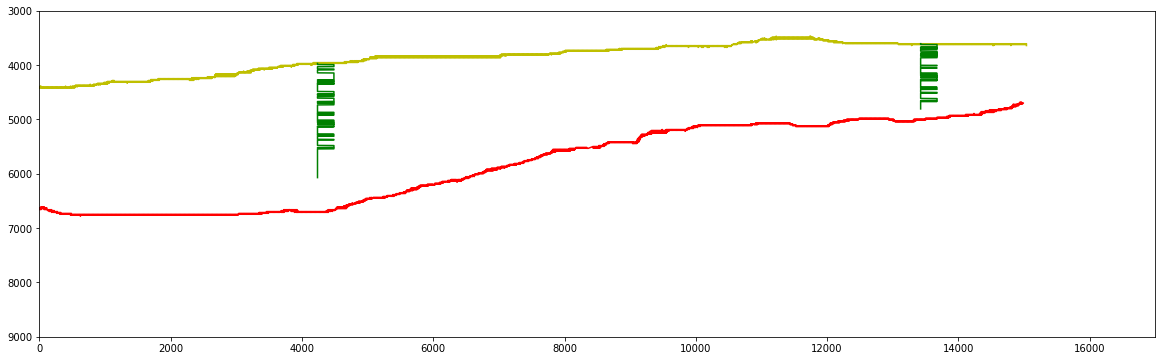

In [26]:
plt.figure(figsize=(20,6))
plt.plot(top.x,top.y,'y') 
plt.plot(bottom.x,bottom.y,'r')
plt.plot(well_A_upscale.Score*resolution_x,well_A_upscale.Tops,'g')
plt.plot(well_B_upscale.Score*resolution_x,well_B_upscale.Tops,'g')
plt.xlim(0,17000) 
plt.ylim(3000,9000) 
plt.gca().invert_yaxis() 
#plt.text(star_a_x, star_a_y-10, str(star_a_x),horizontalalignment='center')
#plt.text(star_b_x, star_b_y-10, str(star_b_x),horizontalalignment='center')
plt.show()